# ECON 516: Replication of Huggett (1993)
### Giulia Lo Forte - November 7, 2020
-----

Here you can find the code and results for the replication of Huggett (1993).

I am using a grid method approach.
It takes a lot of time to run, but the results are quite satisfying.

I have noticed that Jupyter Notebook takes a little bit more time to run compared to a simple Julia file, probably due to something off in my own computer.
Therefore, I am also attaching the same code written in a Julia file.

This document is organized as follows: a brief summary of the model and its equilibrium; a brief explanation of the theoretical and computational steps to follow in order to solve the model; a comparison of the results in two different settings; a brief list of checks and graphs I have performed in smaller parts of the code.


-------

In [1]:
using LinearAlgebra, Random, Distributions, Statistics, Plots, BenchmarkTools, Interpolations

----
## Model and Equilibrium
The model encompasses the following elements:
- a continuum of agents with mass 1;
- in each period, the agent is endowed with $e \in E=\{e_h; e_l\}$ with $e_h > e_l$ according to a Markov Process $\pi(e'|e)= Pr(e_{t+1}=e' | e_t = e) > 0 $ independent across agents;
- the utility function is
$$ E\big[ \sum_{t=0}^{\infty} \beta^t u(c_t) \big] $$
with $\beta \in (0,1) $, $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$ and $\sigma >1$;
- the budget constraint in each period is $c + a' q \leq a+e$ with $a' \geq \underline{a}$ and $\underline{a} < 0$.

Define the individual state variable as $x = (a,e) \in X$ with $X = A$x$E$, $A=[\underline{a},\infty)$.
Let $q>0$ be the constant price for next period's credit.

The decision problem for the individual is
$$ v(x;q) = \max_{(c,a') \in \Gamma(x;q)} u(c) + \beta \sum_{e'} v(a',e';q) \pi(e'|e) $$
where $\Gamma(x;q) = \{(c,a') : c+qa' \leq a+e; c \geq 0; a' \geq a \}$.


Let $\overline{a}$ be an endogenously determined level of credit balance that individual agents never overtake, then $S=[\underline{a},\overline{a}]$x$E$ and $\beta_S$ is the the corresponding Borel $\sigma$-algebra.
$\forall B \in \beta_S$, $\psi(B)$ is the mass of agents whose individual state vector lies in $B$.

Now define the transition probability $P: S$x$\beta_S \rightarrow [0,1]$ where $P(x,B)$ is the probability that an agent with state $x$ will have a state vector lying in $B$ in the next period.

#### Definition
A *stationary equilibrium* is $c(x)$, $a(x)$, $q$, and $\psi$ such that:
- $c(x)$ and $a(x)$ are optimal decision rules, given $q$;
- markets clear: $\int_S c(x) d\psi = \int_S e d\psi$ and $\int_S a(x) d \psi = 0$;
- $\psi$ is stationary: $\psi(B)=\int_S P(x,B) d \psi \quad \forall B \in \beta_S$.

#### Theorem 1
Define $T: C(X) \rightarrow C(X)$, with $C(X)$ being the space of bounded, continuous, real-valued functions on $X$, as:
$$ (Tv)(x;q) = \max_{(c,a') \in \Gamma(x;q)} u(c)+\beta \sum_{e'} v(a',e';q) \pi(e'|e) $$

For $q>0$ and $\underline{a} + e_l + \underline{a}q < 0$ there exists a unique colution $v(x;q) \in C(X)$ and $T^n v_0$ converges uniformly to $v$ from any starting point $v_0$.

#### Theorem 2
Define $W: M(S) \rightarrow M(S)$, with $M(S)$ being the space of probability measures $(S,\beta_S)$, as
$$ (W\psi)(B) = \int_S P(s,B) d \psi \quad \forall B \in \beta_S$$

If the conditions for Theorem 1 are satisfied, $\beta < q$, $\pi(e_h|e_h) \geq \pi(e_h|e_l)$, then there exists a unique stationary probability measure $\psi$ and $W^n\psi_0$ converges weakly to $\psi$.


-----

## Calibration
Calibration is performed in order to match the variability of labour earnings (as measured in Kydland (1984)) and the average duration of unemployment (as measured in the Handbook of Labor Statistic).

The author uses the following setting:
- $e_h = 1.0$, $e_l = 0.1$, $\pi(e_h|e_h) = 0.925$, $\pi(e_h|e_l) = 0.5$;
- 6 model periods in one year, therefore the standard deviation is 20\% and the average duration of $e_l$ is 2 model periods;
- $\beta=0.9932$;
- $\sigma = 1.5$;
- $\underline{a} \in \{ -2, -4, -6, -8 \}$.

----

## Computation
The computation procedure can be broken down in three steps.
I am going to write a separate code for each one of the steps, and then combine them together to find the solution of the model.


#### Step 1
Given $q$, compute $a(x;q)$ by iterating
$$ (Tv)(x;q) = \max_{(c,a') \in \Gamma} u(c) + \beta \sum_{e'} v(a',e';q) \pi(e'|e) $$
from an arbitrary, concave, bounded, differentiable function $v_0$.
The FOC of the problem in $Tv_0$ is
$$ u'(a+e-a'q)q \geq \beta \sum_{e'} v'_0(a',e')\pi(e'|e) $$
The solution to this FOC is labelled $a_1(x;q)$. The FOC in $T^2v_0$ is the same but with $Tv'_0(x) = u'(a+e-a_1(x;q)q)$ in place of $v'_0(x)$. The solution is now labelled $a_2(x;q)$, and iteration continues until convergence of the functions $a$.

On a computer, we need to perform some changes:
1. compute $u'(a+e-a'q)$ and $v'_0(a,e)$ on finite grids on $X$x$A$ and $X$, using linear interpolation between gridpoints; in practice, for $A$ we use 150-350 evenly spaced gridpoints, with gridsize being 0.03-0.1 units of credit balances;
2. solve for $a_1(a,e)$ on gridpoints using the FOC;
3. repeat until convergence.

**What I am doing in practice:**

I have chosen to employ a grid search in `step1`. In each point of the grid `A` in which consumption is weakly positive, I compute the value function `V` and then find the value of $a'$ that corresponds to the maximum value function attainable by the individual starting from a given point in the grid.
When consumption is negative, I replace the value function with $-\infty$.

I then repeat the process until convergence of the maximum value function, that is convergence of the policy function.

In [2]:
# Function for step 1: for a given q, find the optimal policy a'
# Leave q generic as a guess (q>1)
function step1(A, E, Π, q, β, σ; v_guess = 0.0, maxT = 600, tol = 0.01)
    
    a_size = length(A)
    e_size = size(E)[1]
    
    v0 = v_guess .* ones(a_size, e_size)
    v_update = zeros(a_size, e_size)
    pol_func = zeros(a_size, e_size)
    
    # Define the utility function
    u(c) = (c.^(1-σ)) ./ (1 - σ) # consider putting this outside the function for more flexibility of the code!
    
    # Iteration of value function
    normdiff = Inf
    t = 1
    
    while normdiff > tol && t <= maxT
        
        # Do linear interpolation of the value function on knots (A,E)
        v_interpol = LinearInterpolation((A, E), v0)
        
        # Replace new value function with solution
        for a = 1:a_size
            for e = 1:e_size
                
                # Generate value function V
                # If c <= 0, set value function to -∞
                V(x) = ((E[e] + A[a] - q*x) <= 0) ? -Inf :
                   u(E[e] + A[a] - q*x) + β*(v_interpol(x, E[1])* Π[e,1] + v_interpol(x, E[2])* Π[e,2])
                
                # Find the maximum
                aux = findmax(V.(A))      # (maximum, index)
                v_update[a,e] = aux[1]    # actual maximum value
                pol_func[a,e] = A[aux[2]] # policy function a'
                
            end
        end
        
        t += 1
        normdiff = maximum(abs.(v_update - v0))
        
        # v0 = v_update  # this is mutable!
        v0 = copy(v_update)
        
    end
    
    return pol_func
    
end

step1 (generic function with 1 method)

#### Step 2
Given $a(x;q)$, iterate on $\psi_{n+1}(B) = \int_S P(x,B) d \psi_n $ from an arbitrary $\psi_0 \in M(S)$.
Then use $\psi$ to compute $\int_S a(x;q) d \psi$ and obtain $q$.

On a computer, define the following function on gridpoints using interpolation for in-between gridpoints:
$$ F_0(a,e) = \psi_0 \big(\{ x: x_1 \leq a, x_2 =e \} \big) $$

Then iterate on 
$$ F_{t+1}(a',e') = \sum_e \pi(e'|e)F_t(a^{-1}(^{.},e)(a'),e) $$
on gridpoints $(a',e')$.
Define $a^{-1}(^{.},e)(\underline{a})$ as the maximum $a$ such that $\underline{a}$ is chosen when the state is $(a,e)$.
Iterate until $F_t$ converges.

**What I am doing in practice:**

I first define function `pol_inv` which computes the inverse of the policy function.
I compute it as the element in the grid of `A` such that `pol_func(A, E)` is the closest to $a'$.

However, note some adjustments:
1. if $a'$ is smaller than all the values of the policy function, then we set $a$ to $\underline{a}$;
2. if $e'$ is the best shock and $a'$ is bigger than any value of the optimal policy function, then we set $a$ to the endogenous $\overline{a}$ corresponding to the intersection with the 45° line.

Once I have defined the inverse of the policy function, I generate the function `step2` which finds the stationary distribution $\Psi$.
As stated above, the code computes the updated distribution using the initial guess distribution, the inverse of the policy function, and the transition probabilities.
The code then iterates over the updated distributions until they converge to the same value.

For the initial guess distribution, note that $\Psi$ is the cumulative distribution over any $(a, e)$.
Therefore, the initial guess distribution must reach value $1$ over all the grid points for $a$ and $e$.
I am assuming that individuals split equally across the two values of the exogenous state variable $e$, and then they distribute uniformly across the values of $a$ for a given $e$.
In practice, the initial guess cumulative distribution function is given by a range going from $0.0$ to $0.5$ with as many steps as the number of gridpoints preceding the endogenous $\underline{a}$ for each value of $e$.
Summing across the two values of $e$ then gives $1$.

In [3]:
# Define the function a^{-1}
function pol_inv(A, pol_func, aprime, eprime)
     
    # if a' < minimum value of policy function, then a must be a_lowerbar
    if minimum(pol_func[:, eprime]) > A[aprime]
        
        return 1
    
    # when e'=2, be careful to distinguish pre and post cross with 45° line (endogenous a_UpperBar)   
    #elseif eprime == 2 && minimum(pol_func[:, eprime]) <= A[aprime]
    elseif eprime == 2
        
        return min(findlast(pol_func[:, eprime] .<= A[aprime]), 
            findfirst((pol_func[:, eprime] - A) .< 0.01))
    
    # in any other case, find element of A such that policy function is closest to a'    
    else
        
        return findlast(pol_func[:, eprime] .<= A[aprime])
        
    end   
    
end

pol_inv (generic function with 1 method)

In [4]:
# Define function for step2: loop to the stationary distribution
function step2(A, E, Π, pol_func; tol = 0.01, maxT = 600)
    
    # retrieve dimensions
    a_size = length(A)
    e_size = size(E)[1]
    
    # Find endogenous position where a' = a
    aBar = findlast((pol_func[:,2] - A) .< tol)
    cut = max(aBar, 2)           # if aBar = 1 then range will not work
    
    aux1 = range(zero(eltype(A)), one(eltype(A))/e_size, length = cut)
    aux2 = ones(eltype(A), a_size - cut)/e_size
    aux = [aux1; aux2]           # 350x1
    F0 = repeat(aux, 1, e_size)  # 350x2
    
    F_update = copy(F0)
    
    # Iteration of distribution
    normdiff = Inf
    t = 1
    
    while normdiff > tol && t <= maxT
        
        for a = 1:a_size
            for e = 1:e_size
                     
                F_update[a,e] = Π[1, e] * F0[pol_inv(A, pol_func, a, 1), 1] + 
                          Π[2, e] * F0[pol_inv(A, pol_func, a, 2), 2]
                
            end
        end       
        
        t += 1
        normdiff = maximum(abs.(F_update - F0))
        
        F0 = copy(F_update)
        
    end
    
    
    return F_update
    
end

step2 (generic function with 1 method)

#### Step 3
Update $q$ and repeat the first two steps until market clearing is approximately completed.

Choose the initial $q$ as the midpoint of the set of candidate prices.
The new value is then increased if there is excess demand for credit, decreased if there is excess supply.

The criterion used for market clearing is that excess demand is within $0.0025$ units of zero.

**What I am doing in practice:**

First, define function `mktclearing` that computes the demand for assets $\int_S a(x) d \psi$ using the gridpoints, the policy function, and the stationary distribution as inputs.
Recall that, for market clearing, we only need $\int_S a(x) d \psi = 0$.

Then, define the function `step3` that, starting from a guess initial value of price $q$, solves for the previous two steps and iterates up until the market for assets sums to zero.
I try not to have a "jumpy" update in prices by using the following updating procedure:
- if there is excess demand, the new price is equal to the old price plus a fraction of the tolerance level to determine that there is no excess demand;
- if there is excess supply, the new price is equal to the old price diminished by the tolerance level.

In [5]:
# Define the function for market clearing
function mktclearing(A, E, pol_func, F_update)
    
    # retrieve dimensions
    a_size = length(A)
    e_size = size(E)[1]
    
    # initialize market for update
    market = 0.0
    
    for a = 2:a_size
        for e = 1:e_size
            
            market += pol_func[a, e] * (F_update[a, e] - F_update[a-1, e])
            
        end
    end
    
    return market
    
end

mktclearing (generic function with 1 method)

In [6]:
# Define the function for step3 (price iteration)
function step3(A, E, Π, q0, β, σ; maxT = 100, tol_iterations = 0.01, tol_market = 0.0025, tol_q = 0.001, weight = 0.5)
    
    @assert q0 > β
    
    q = q0
    solStep1 = step1(A, E, Π, q, β, σ; tol = tol_iterations)
    solStep2 = step2(A, E, Π, solStep1; tol = tol_iterations)
     
    # Start price iteration
    normdiff = Inf
    t = 1
    
    while normdiff > tol_q && t <= maxT
        
        # solve step1
        solStep1 = step1(A, E, Π, q, β, σ; tol = tol_iterations)
                
        # solve step2
        solStep2 = step2(A, E, Π, solStep1; tol = tol_iterations)
        
        # compute market clearing
        market = mktclearing(A, E, solStep1, solStep2)
        
        
        # update q based on market clearing
        
        # increase guess if market > 0 (but just by a little bit)
        if market > 0 && abs(market) > tol_market  
            q = q + (1 - weight) * tol_market
        
        # decrease guess if market < 0 (but just by a little bit)
        elseif market < 0 && abs(market) > tol_market
            q = q - (1 - weight) * tol_market
        
        # if abs(market) < tol_market, then no need to update q    
        else 
            q = q
        end
        
        t = t + 1
        normdiff = abs(q - q0)
        
        q0 = q
        
    end
    
    return (q = q, policy = solStep1, Ψ = solStep2)
    
end

step3 (generic function with 1 method)

----
## Results
### Relative risk aversion $\sigma = 1.5$
Let's solve the model with $\sigma = 1.5$ and considering all the possible values of $\underline{a}$ in the set $\{-2, -4, -6, -8\}$.

The initial guess is $q=1.1$.
The grid for $A$ is given by $350$ points, from $\underline{a}$ to $10$. Then the solver algorithm will find the endogenous $\overline{a}$.

Results are reported in the table below.

In [ ]:
# Do computations over a set of lower bounds with σ = 1.5

# Parameters
σ = 1.5
β = 0.9932
BoundSet = (-2.0, -4.0, -6.0, -8.0)

# Exogenous state variable grid
eH = 1.0
eL = 0.1
E = [eL; eH]     

# Transition matrix: Pr(j|i) = Π(i,j) (columns sum to 1)
πHH = 0.925 # e_H | e_H
πHL = 0.5   # e_H | e_L
Π = [1 - πHL  πHL
    1 - πHH πHH]

# Guess
q0 = 1.1

# Start loop over lower bound
for a_lb in BoundSet
    
    # Generate grid points for endogenous state variable
    a_max = 5
    a_size = 350
    A = range(a_lb, a_max, length = a_size)
    A = [A; ];
    
    (q, policy, Ψ) = step3(A, E, Π, q0, β, σ)
    

end

The following table reports the results obtained by this algorithm and a comparison with the original results of Huggett (1993):

| Credit limit | Price $q$ | Original result |
|:------------ | --------- |:---------------:|
|    -2.0      |   1.0125  |     1.0124      |
|    -4.0      |   0.9975  |     0.9962      |
|    -6.0      |   0.9950  |     0.9944      |
|    -8.0      |   0.9925  |     0.9935      |

### Relative risk aversion $\sigma = 3.0$
Now I solve the model with $\sigma = 3$ and considering all the possible values of $\underline{a}$ in the set $\{-2, -4, -6, -8\}$.

I keep the same initial conditions as before: the initial guess is $q=1.1$, and the grid for $A$ is given by $350$ points, from $\underline{a}$ to $10$.
Then the solver algorithm will find the endogenous $\overline{a}$.

Results are reported in the table below.

In [ ]:
# Do computations over a set of lower bounds with σ = 3

# Parameters
σ = 3.0
β = 0.9932
BoundSet = (-2.0, -4.0, -6.0, -8.0)

# Exogenous state variable grid
eH = 1.0
eL = 0.1
E = [eL; eH]     

# Transition matrix: Pr(j|i) = Π(i,j) (columns sum to 1)
πHH = 0.925 # e_H | e_H
πHL = 0.5   # e_H | e_L
Π = [1 - πHL  πHL
    1 - πHH πHH]

# Guess
q0 = 1.1

# Start loop over lower bound
for a_lb in BoundSet
    
    # Generate grid points for endogenous state variable
    a_max = 5
    a_size = 350
    A = range(a_lb, a_max, length = a_size)
    A = [A; ];
    
    (q, policy, Ψ) = step3(A, E, Π, q0, β, σ)
    

end

The following table reports the results obtained in this algorithm and compares them with the original results of Huggett (1993):

| Credit limit | Price $q$ | Original result |
|:------------ | --------- |:---------------:|
|    -2.0      |   1.0450  |     1.0448      |
|    -4.0      |   1.0050  |     1.0045      |
|    -6.0      |   0.9975  |     0.9970      |
|    -8.0      |   0.9925  |     0.9940      |

---------------------
---------------------
## Checks and Graphs
While I was writing the code, I have run some checks along the way to see if each small piece of the code was working as expected.

First, set some of the parameters and initial conditions:

In [9]:
# Set parameters
β = 0.9932
σ = 1.5
a_lb = -2.0;

In [10]:
# Generate grid points for exogenous state variable
eH = 1.0
eL = 0.1
E = [eL; eH]     
πHH = 0.925 # e_H | e_H
πHL = 0.5   # e_H | e_L
# Transition matrix: Pr(j|i) = Π(i,j) (columns sum to 1)
Π = [1 - πHL  πHL
    1 - πHH πHH]

2×2 Array{Float64,2}:
 0.5    0.5
 0.075  0.925

In [ ]:
# Generate grid points for endogenous state variable
a_max = 10
a_size = 350
A = range(a_lb, a_max, length = a_size)  
A = [A; ];

### Checks for Step1

In [12]:
# Define the utility function and its derivative
u(c) = c.^(1-σ) ./ (1 - σ)
Du(u) = c -> ForwardDiff.derivative(u, c)

Du (generic function with 1 method)

In [13]:
e_size = size(E)[1]
# Intial guess of v
v_guess = 0.0
v0 = v_guess .* ones(a_size, e_size)

# Matrices where to store update and policy function
v_update = zeros(a_size, e_size)
pol_func = zeros(a_size, e_size); # a_size x size(E): 350x2

In [14]:
# Check that Step1 works
q = 1.1
solStep1 = step1(A, E, Π, q, β, σ) # 350x2 matrix

350×2 Array{Float64,2}:
 -2.0      -1.82808
 -2.0      -1.82808
 -2.0      -1.7937
 -2.0      -1.75931
 -2.0      -1.75931
 -2.0      -1.72493
 -1.96562  -1.69054
 -1.96562  -1.69054
 -1.96562  -1.65616
 -1.93123  -1.62178
 -1.93123  -1.62178
 -1.89685  -1.58739
 -1.89685  -1.55301
  ⋮        
  6.90544   7.59312
  6.93983   7.62751
  6.93983   7.66189
  6.97421   7.66189
  7.0086    7.69628
  7.04298   7.73066
  7.07736   7.76504
  7.11175   7.79943
  7.11175   7.83381
  7.14613   7.86819
  7.18052   7.90258
  7.2149    7.90258

### Checks for Step2

In [15]:
# Briefly check that pol_inv works
pol_inv(A, solStep1, 14, 2)
pol_inv(A, solStep1, 37, 1)

65

In [16]:
# Check what F0 is
tol = 0.01
a_size = length(A)
e_size = size(E)[1]
    
# Find endogenous position where a' = a
aBar = findlast((solStep1[:,2] - A) .< tol)
cut = max(aBar, 2)           # if aBar = 1 then range will not work
    
aux1 = range(zero(eltype(A)), one(eltype(A))/e_size, length = cut)
aux2 = ones(eltype(A), a_size - cut)/e_size  # can be empty
aux = [aux1; aux2]           # 350x1
F0 = repeat(aux, 1, e_size)  # 350x2

350×2 Array{Float64,2}:
 0.0         0.0
 0.00143266  0.00143266
 0.00286533  0.00286533
 0.00429799  0.00429799
 0.00573066  0.00573066
 0.00716332  0.00716332
 0.00859599  0.00859599
 0.0100287   0.0100287
 0.0114613   0.0114613
 0.012894    0.012894
 0.0143266   0.0143266
 0.0157593   0.0157593
 0.017192    0.017192
 ⋮           
 0.484241    0.484241
 0.485673    0.485673
 0.487106    0.487106
 0.488539    0.488539
 0.489971    0.489971
 0.491404    0.491404
 0.492837    0.492837
 0.494269    0.494269
 0.495702    0.495702
 0.497135    0.497135
 0.498567    0.498567
 0.5         0.5

In [17]:
# Run step2 to check it works
Ψ = step2(A, E, Π, solStep1)

350×2 Array{Float64,2}:
 0.00845739  0.0315834
 0.00899785  0.0321238
 0.0094932   0.0326192
 0.0108208   0.0339468
 0.0118355   0.0349615
 0.012096    0.0358911
 0.0122379   0.0366257
 0.012573    0.0389833
 0.0128391   0.0404892
 0.0132844   0.0439521
 0.0135591   0.0460716
 0.0142069   0.0527921
 0.015033    0.0609509
 ⋮           
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115
 0.0199605   0.097115

### Checks for Step3

In [18]:
# Test if step3 works
q0 = 1.1
σ = 1.5
a_lb = -2.0
(q, policy, Ψ) = step3(A, E, Π, q0, β, σ)

(q = 1.010000000000002, policy = [-2.0 -1.656160458452722; -2.0 -1.6217765042979944; … ; 8.693409742120345 9.51862464183381; 8.727793696275072 9.553008595988539], Ψ = [0.0033878443899294074 0.018243057371691223; 0.0037279484659432727 0.01858316144770509; … ; 0.0426087459426575 0.2835743217507522; 0.0426087459426575 0.2835743217507522])

### Plots

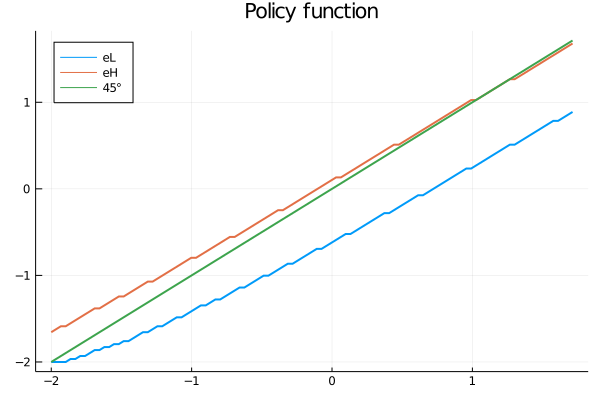

In [19]:
# Plot policy functions to check what is happening

# Find endogenous a upper bar (use aUB+20 in graphs to see the intersection)
aUB = findfirst(policy[:,2] - A[:] .<= 0.001)  

# Unconstrained plot
p1 = plot(A, [policy A], linewidth = 2, title = "Policy function", label = ["eL" "eH" "45°"], legend =:topleft)

# Constrained to endogenous a_UpperBar
p1B = plot(A[1:aUB+20], [policy[1:aUB+20,:] A[1:aUB+20]], linewidth = 2, 
    title = "Policy function", label = ["eL" "eH" "45°"], legend =:topleft)

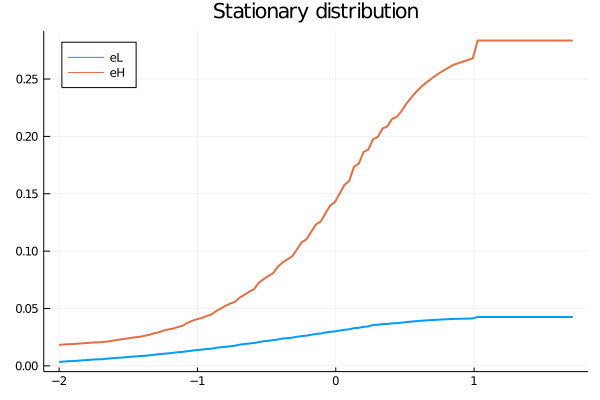

In [20]:
# Plot distribution Ψ to check what is happening

# Unconstrained
p2 = plot(A, Ψ, linewidth = 2, title = "Stationary distribution", label = ["eL" "eH"], legend =:topleft)

# Constrained to endogenous a_UpperBar
p2B = plot(A[1:aUB+20], Ψ[1:aUB+20,:], linewidth = 2, 
    title = "Stationary distribution", label = ["eL" "eH"], legend =:topleft)

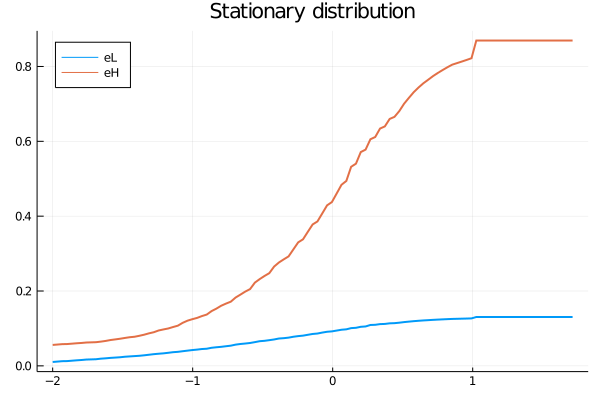

In [22]:
# Plot rescaled distribution Ψ
# \Psi could not 'sum' to 1 after the update
scale = sum(Ψ[end, :])
    F = Ψ ./ scale

# Unconstrained
p3 = plot(A, F, linewidth = 2, title = "Stationary distribution", label = ["eL" "eH"], legend =:topleft)

# Constrained to endogenous a_UpperBar
p3B = plot(A[1:aUB+20], F[1:aUB+20,:], linewidth = 2, 
    title = "Stationary distribution", label = ["eL" "eH"], legend =:topleft)